# This Cat Doesn't Exist
## Generative Adversarial Networks Version

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import IPython.display as ipd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import time
import glob
from PIL import Image

# Dataset Definitions

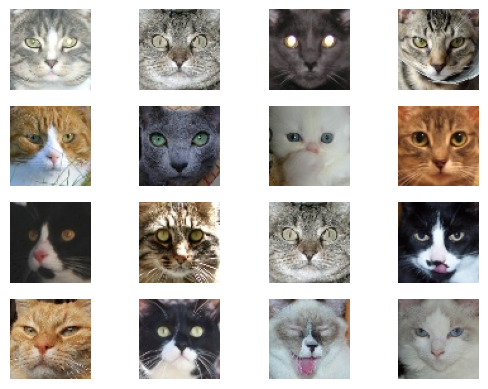

In [5]:
def plot_samples(XGen):
    """
    Plot a set of examples from the dataset/generator on a square grid
    
    Parameters
    ----------
    XGen: torch.tensor(n_examples, 3, dim, dim)
        A batch of examples to plot
    """
    k = int(np.sqrt(XGen.shape[0]))
    for i in range(XGen.shape[0]):
        plt.subplot(k, k, i+1)
        Xi = XGen[i, :, :, :].detach().cpu().numpy()
        Xi = np.moveaxis(Xi, 0, 2)
        Xi[Xi < 0] = 0
        Xi[Xi > 1] = 1
        plt.imshow(Xi)
        plt.axis("off")

class CatData(Dataset):
    def __init__(self, foldername, imgres=64, train=True):
        self.images = glob.glob("{}/*".format(foldername))
        self.preprocess = transforms.Compose([
            transforms.Resize(imgres),
            transforms.ToTensor()
        ])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = Image.open(self.images[idx])
        img = self.preprocess(img)
        if torch.max(img) > 1:
            img /= 255
        return img
    
traindata = CatData("cats")

samples = DataLoader(traindata, batch_size=16, shuffle=True)
plot_samples(next(iter(samples)))

# Model Definitions

In [6]:
class Discriminator(nn.Module):
    def __init__(self, depth=4, dim_latent=64, dim_img=64, in_channels=3, start_channels=64):
        """
        depth: int
            How many convolutional layers there are in the encoder/decoder
        dim_latent: int
            Dimension of the flattened latent space
        dim_digit: int
            Width/height of input image
        in_channels: int
            Number of channels of input image
        start_channels: int
            Number of channels out of the first convolutional layer
        """
        super().__init__()
        
        self.dim_latent = dim_latent
        in_orig = in_channels
        layers = []
        out_channels = start_channels
        
        for _ in range(depth):
            layers.append(nn.Conv2d(in_channels=in_channels, 
                                         out_channels=out_channels, 
                                         kernel_size=4, 
                                         stride=2, 
                                         padding=1,
                                         bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.LeakyReLU())
            in_channels = out_channels
            out_channels *= 2
                
        dim = in_channels * (dim_img // 2**depth)**2
        layers += [nn.Flatten(), nn.Linear(dim, 1)]
        self.discriminator = nn.Sequential(*layers)
    
    def forward(self, X):
        return self.discriminator(X)
        

class Generator(nn.Module):
    def __init__(self, depth=4, dim_latent=64, dim_img=64, in_channels=3, end_channels=64):
        """
        depth: int
            How many convolutional layers there are in the encoder/decoder
        dim_latent: int
            Dimension of the latent space
        dim_digit: int
            Width/height of input image
        in_channels: int
            Number of channels of input image
        end_channels: int
            Number of channels out of the second to last convolutional layer
        """
        super().__init__()
        self.dim_latent = dim_latent
        
        imgres = dim_img//(2**depth)
        in_channels = end_channels*(2**(depth-1))
        shape_latent = (in_channels, imgres, imgres)
        self.dim_latent = dim_latent
        layers = [nn.Linear(dim_latent, np.prod(shape_latent)), nn.Unflatten(1, shape_latent), nn.LeakyReLU()]
        for i in range(depth):
            out_channels = 3
            if i < depth - 1:
                out_channels = in_channels // 2
                
            layers.append(nn.ConvTranspose2d(in_channels=in_channels, 
                                             out_channels = out_channels,
                                             kernel_size=4,
                                             stride=2, 
                                             padding=1, 
                                             bias=False))
            layers.append(nn.BatchNorm2d(out_channels))
            if i < depth - 1:
                layers.append(nn.LeakyReLU())
            else:
                layers.append(nn.Sigmoid())
            in_channels = out_channels
        
        self.generator = nn.Sequential(*layers)
            
        
    
    def forward(self, z):
        return self.generator(z)
        
    
    def sample(self, n_examples, device):
        """
        Sample from the latent space and generate the images
        
        Parameters
        ----------
        n_examples: int
            Number of examples to generate
        device: string
            Device for model/tensors
        
        Returns
        -------
        torch.tensor(n_examples, 3, dim_img, dim_img)
            A batch of generated examples
        """
        z = torch.randn(n_examples, self.dim_latent).to(device)
        return self.generator(z)

# Training

In [ ]:
device = 'cuda'
dim_latent = 64
channels = 64
lr = 3e-4

n_epochs = 300
batch_size = 16

generator = Generator().to(device)
discriminator = Discriminator().to(device)

g_optimizer = torch.optim.Adam(generator.parameters(), lr)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr)

loss_fn = nn.BCEWithLogitsLoss()

for epoch in range(n_epochs):
    loader = DataLoader(traindata, batch_size=batch_size, shuffle=True)
    gen_loss = 0
    discrim_loss = 0
    for i, X in enumerate(loader):
        X = X.to(device)
        if len(X) == batch_size:
            # train generator
            g_optimizer.zero_grad()
            z = torch.randn(batch_size, channels).to(device)
            Xest = generator(z).to(device)
            Yest = discriminator(Xest).to(device)
            losses = loss_fn(Yest, torch.ones((len(Yest), 1)).to(device))
            losses.backward()
            g_optimizer.step()
            
            # train discriminator
            d_optimizer.zero_grad()
            z = torch.randn(batch_size, channels).to(device)
            Xest = generator(z).to(device)
            Yest = discriminator(Xest).to(device)
            losses_false = loss_fn(Yest, torch.zeros((len(Yest), 1)).to(device))
            Yest = discriminator(X)
            Yest = Yest.to(device)
            losses_real = loss_fn(Yest, torch.ones((len(Yest), 1)).to(device))
            losses = losses_false + losses_real
            losses.backward()
            d_optimizer.step()
            
    Xest = generator.sample(batch_size, device)
    plot_samples(Xest)
    plt.savefig("Training/{}.png".format(epoch))